# Twitter Sentiment Analysis of COVID-19 in the state of Virginia

## This file specifically looks at sentiment scores and other metrics on a weekly basis.

In [1]:
import re,string
import nltk
import pickle

from pprint import pprint
import pandas as pd
import numpy as np
import os
import matplotlib
import functools
from functools import reduce

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as pyplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import multiprocessing
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import spacy

# Plotting tools
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

RANDOM = 36 # To be reproducible

# set working file
os.chdir('/Users/rachelmartonik/MSDS_498_Capstone/data')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data - Stay-At-Home & Quarantine

I am pulling daily data from the Twitter application user interface (API) using the rtweet package in R. Data collection is limited to tweets posted in Virginia according to Twitter. Two daily pulls are run:

    1.	COVID pull that uses the search terms: #COVID, COVID, COVID-19, #COVID-19, coronavirus, and #coronavirus. Data collection started April 7th.
    2.	Stay-at-home pull that uses the search terms: #stayhome, #stayathome, #Quarantine, quarantine, and #SocialDistancing. Data collection started April 7th.

This notebook focuses on the Stay-At-Home Data Set.

## Create weekly DSS County Files


In [367]:
import pandas as pd
DSS = pd.read_pickle("DSS_200516.pickle")
DSS.head()

,county_name,04-07,04-08,04-09,04-10,04-11,04-12,04-13,04-14,04-15,...,05-16,05-17,05-18,05-19,05-20,05-21,05-22,05-23,05-24,NumOfTweets
2,alexandria city,0.099242,0.094447,0.111315,0.090237,-0.000913,0.046577,0.110444,0.117010,0.099704,...,0.067790,0.027501,0.135621,0.120466,0.081155,0.099248,0.110340,0.106803,0.064277,11116
7,arlington county,0.112952,0.091583,0.114026,0.130715,0.028340,0.047672,0.116204,0.145737,0.127005,...,0.123439,0.115643,0.158987,0.077543,0.048882,0.146787,0.194918,0.071212,0.036388,12109
9,bedford county,0.136833,-0.054782,-0.079687,0.102470,-0.002750,-0.160787,-0.023064,-0.037687,-0.059507,...,0.073367,0.208040,-0.307750,-0.105750,-0.268567,-0.081140,0.395000,0.000000,-0.038600,381
11,bristol city,0.033833,0.444936,0.311230,0.084631,0.038600,-0.590500,0.108033,0.038093,0.046225,...,0.035957,0.335250,0.095529,0.179500,0.120271,0.222283,0.149009,0.061217,0.348500,443
19,charlotte county,0.007176,0.047388,0.044376,0.028057,-0.063068,0.094638,-0.088737,-0.116542,-0.038546,...,-0.040275,-0.024491,-0.084100,0.149715,0.079253,0.013164,0.141568,-0.072717,0.046545,974


In [368]:
# Weekly DSS Files - I averaged the DSS scores. I probably should go back and run the weelky scores separately. 
# Keep this for now, but go back and redo if find correlation.
Week1_DSS =DSS[['county_name','04-07', '04-08', '04-09', '04-10', '04-11', '04-12']]
Week2_DSS =DSS[['county_name','04-13', '04-14', '04-15', '04-16', '04-17', '04-18', '04-19']]
Week3_DSS =DSS[['county_name','04-20', '04-21', '04-22', '04-23', '04-24', '04-25', '04-26']]
Week4_DSS =DSS[['county_name','04-27', '04-28', '04-29', '04-30', '05-01', '05-02', '05-03']]
Week5_DSS =DSS[['county_name','05-04', '05-05', '05-06', '05-07', '05-08', '05-09', '05-10']]
Week6_DSS =DSS[['county_name','05-11', '05-12', '05-13', '05-14', '05-15', '05-16', '05-17']]
Week7_DSS =DSS[['county_name','05-18', '05-19', '05-20', '05-21', '05-22', '05-23', '05-24']]

In [369]:
# Take average DSS for weekly average DSS
Week1_DSS['W1_DSS'] = Week1_DSS.iloc[:, [1, 2, 3, 4]].mean(axis=1)
Week2_DSS['W2_DSS'] = Week2_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week3_DSS['W3_DSS'] = Week3_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week4_DSS['W4_DSS'] = Week4_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week5_DSS['W5_DSS'] = Week5_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week6_DSS['W6_DSS'] = Week6_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week7_DSS['W7_DSS'] = Week7_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [370]:
Week2_DSS

,county_name,04-13,04-14,04-15,04-16,04-17,04-18,04-19,W2_DSS
2,alexandria city,0.110444,0.117010,0.099704,0.073425,0.087298,0.060628,0.052806,0.085902
7,arlington county,0.116204,0.145737,0.127005,0.120145,0.131913,-0.025198,0.017744,0.090507
9,bedford county,-0.023064,-0.037687,-0.059507,-0.019862,-0.302863,-0.085333,0.002543,-0.075111
11,bristol city,0.108033,0.038093,0.046225,0.051912,0.015182,0.225133,0.336525,0.117301
19,charlotte county,-0.088737,-0.116542,-0.038546,0.020504,0.045732,-0.167310,-0.130600,-0.067929
20,charlottesville city,0.071940,0.013100,0.058481,0.067961,0.050761,-0.064735,0.100646,0.042594
22,chesterfield county,0.006169,0.155741,0.038811,0.123817,0.246305,-0.011072,0.287733,0.121072
26,culpeper county,0.071865,0.171005,0.084894,0.077700,0.092643,0.100953,0.145394,0.106351
28,danville city,0.868200,0.238043,0.187582,0.089570,0.443850,0.217780,-0.700300,0.192104
31,essex county,0.090360,0.073188,0.089445,0.049804,0.096188,0.005969,0.045462,0.064345


In [377]:
Week1_DSS = Week1_DSS[['W1_DSS']]
Week2_DSS = Week2_DSS[['W2_DSS']]
Week3_DSS = Week3_DSS[['W3_DSS']]
Week4_DSS = Week4_DSS[['W4_DSS']]
Week5_DSS = Week5_DSS[['W5_DSS']]
Week6_DSS = Week6_DSS[['W6_DSS']]
Week7_DSS = Week7_DSS[['county_name', 'W7_DSS']]


In [378]:
# Weekly Covid Cases data - use last day in week for cases count
Week1_cases =cases[['county_name', '04-12']]
Week2_cases =cases[['county_name', '04-19']]
Week3_cases =cases[['county_name', '04-26']]
Week4_cases =cases[['county_name', '05-03']]
Week5_cases =cases[['county_name', '05-10']]
Week6_cases =cases[['county_name', '05-17']]
Week7_cases =cases[['county_name', '05-24']]
Week1_cases.columns=['county_name', 'W1_cases']
Week2_cases.columns=['county_name', 'W2_cases']
Week3_cases.columns=['county_name', 'W3_cases']
Week4_cases.columns=['county_name', 'W4_cases']
Week5_cases.columns=['county_name', 'W5_cases']
Week6_cases.columns=['county_name', 'W6_cases']
Week7_cases.columns=['county_name', 'W7_cases']
Week1_cases

,county_name,W1_cases
0,accomack county,0.458127
1,albemarle county,0.432514
2,alexandria city,1.265135
3,alleghany county,0.261677
4,amelia county,0.700171
...,...,...
128,york county,0.429077
129,martinsville city,0.000000
130,dickenson county,0.000000
131,bland county,0.000000


In [379]:
# Weekly Covid Deaths data - use last day in week for death count
Week1_deaths =deaths[['county_name', '04-12']]
Week2_deaths =deaths[['county_name', '04-19']]
Week3_deaths =deaths[['county_name', '04-26']]
Week4_deaths =deaths[['county_name', '05-03']]
Week5_deaths =deaths[['county_name', '05-10']]
Week6_deaths =deaths[['county_name', '05-17']]
Week7_deaths =deaths[['county_name', '05-24']]
Week1_deaths.columns=['county_name', 'W1_deaths']
Week2_deaths.columns=['county_name', 'W2_deaths']
Week3_deaths.columns=['county_name', 'W3_deaths']
Week4_deaths.columns=['county_name', 'W4_deaths']
Week5_deaths.columns=['county_name', 'W5_deaths']
Week6_deaths.columns=['county_name', 'W6_deaths']
Week7_deaths.columns=['county_name', 'W7_deaths']
Week1_deaths

,county_name,W1_deaths
0,accomack county,0.000000
1,albemarle county,0.000000
2,alexandria city,0.006390
3,alleghany county,0.000000
4,amelia county,0.000000
...,...,...
124,williamsburg city,0.067622
125,winchester city,0.000000
126,wise county,0.025625
127,wythe county,0.000000


In [380]:
weekly_deaths = pd.concat([Week1_deaths, Week2_deaths, Week3_deaths, Week4_deaths, Week5_deaths, Week6_deaths, Week7_deaths], axis=1)
weekly_deaths = weekly_deaths.loc[:,~weekly_deaths.columns.duplicated()]
weekly_deaths

weekly_cases = pd.concat([Week1_cases, Week2_cases, Week3_cases, Week4_cases, Week5_cases, Week6_cases, Week7_cases], axis=1)
weekly_cases = weekly_cases.loc[:,~weekly_cases.columns.duplicated()]
weekly_cases


,county_name,W1_cases,W2_cases,W3_cases,W4_cases,W5_cases,W6_cases,W7_cases
0,accomack county,0.458127,1.282756,5.711319,12.216725,15.515240,21.012766,22.203897
1,albemarle county,0.432514,0.535941,0.714588,1.015467,1.128297,1.297541,1.391566
2,alexandria city,1.265135,2.447206,3.776237,5.744225,7.622760,9.431009,11.073129
3,alleghany county,0.261677,0.327097,0.327097,0.392516,0.392516,0.457935,0.850451
4,amelia county,0.700171,1.089155,1.166952,1.244749,1.322546,1.400342,1.633733
...,...,...,...,...,...,...,...,...
128,york county,0.429077,0.651013,0.651013,0.695400,0.828562,0.917336,1.006111
129,martinsville city,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
130,dickenson county,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
131,bland county,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [381]:
urban_rural = pd.read_excel('PctUrbanRural_County.xls')
urban_rural

,STATE,COUNTY,STATENAME,COUNTYNAME,county_name,POP_COU,AREA_COU,POP_URBAN,POPPCT_URBAN,AREA_URBAN,...,POP_UC,POPPCT_UC,AREA_UC,AREAPCT_UC,POPDEN_UC,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,POPDEN_RURAL
0,51,1,Virginia,Accomack,accomack county,33164,1164189289,0,0.00,0,...,0,0.00,0,0.00,NaN,33164,100.00,1164189289,100.00,73.8
1,51,3,Virginia,Albemarle,albemarle county,98970,1866599905,54411,54.98,72020020,...,5527,5.58,9035806,0.48,1584.2,44559,45.02,1794579885,96.14,64.3
2,51,5,Virginia,Alleghany,alleghany county,16250,1153727336,7736,47.61,16530458,...,7736,47.61,16530458,1.43,1212.1,8514,52.39,1137196878,98.57,19.4
3,51,7,Virginia,Amelia,amelia county,12690,920142596,0,0.00,0,...,0,0.00,0,0.00,NaN,12690,100.00,920142596,100.00,35.7
4,51,9,Virginia,Amherst,amherst county,32353,1227484444,11756,36.34,38762867,...,0,0.00,0,0.00,NaN,20597,63.66,1188721577,96.84,44.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,51,800,Virginia,Suffolk,suffolk city,84585,1036429624,66287,78.37,119032833,...,0,0.00,0,0.00,NaN,18298,21.63,917396791,88.52,51.7
129,51,810,Virginia,Virginia Beach,virginia beach city,437994,644948896,431273,98.47,349751692,...,0,0.00,0,0.00,NaN,6721,1.53,295197204,45.77,59.0
130,51,820,Virginia,Waynesboro,waynesboro city,21006,38950817,20475,97.47,29112706,...,0,0.00,0,0.00,NaN,531,2.53,9838111,25.26,139.8
131,51,830,Virginia,Williamsburg,williamsburg city,14068,23366983,14068,100.00,23366983,...,0,0.00,0,0.00,NaN,0,0.00,0,0.00,NaN


In [382]:
weekly_DSS_stay = pd.concat([Week7_DSS, Week1_DSS, Week2_DSS, Week3_DSS, Week4_DSS, Week5_DSS, Week6_DSS], axis=1)
weekly_DSS_stay

,county_name,W7_DSS,W1_DSS,W2_DSS,W3_DSS,W4_DSS,W5_DSS,W6_DSS
2,alexandria city,0.102558,0.098810,0.085902,0.066707,0.094970,0.108611,0.101765
7,arlington county,0.104959,0.112319,0.090507,0.102226,0.076196,0.095533,0.106922
9,bedford county,-0.058115,0.026209,-0.075111,-0.054243,-0.069129,-0.102248,0.032375
11,bristol city,0.168044,0.218658,0.117301,0.186105,0.094929,0.093367,0.056468
19,charlotte county,0.039061,0.031749,-0.067929,0.014497,-0.002021,0.072703,0.027806
20,charlottesville city,0.072350,0.075219,0.042594,0.050433,0.081157,0.050968,0.044829
22,chesterfield county,0.019493,-0.008896,0.121072,0.102975,0.060794,-0.007122,0.003884
26,culpeper county,0.095257,0.136908,0.106351,0.082975,0.091694,0.072725,0.092394
28,danville city,-0.020516,0.080147,0.192104,0.082650,0.106554,0.210137,0.059075
31,essex county,0.061302,0.109145,0.064345,0.081910,0.040904,-0.004147,0.060956


In [383]:
Week_DSS_stay_cases = pd.merge(weekly_DSS_stay, weekly_cases, on='county_name', how="left")
Week_DSS_stay_cases.fillna(0, inplace=True)
#Week_DSS_stay_cases.to_csv('Week_DSS_stay_cases.csv')
Week_DSS_stay_cases.head()

Week_DSS_stay_deaths = pd.merge(weekly_DSS_stay, weekly_deaths, on='county_name', how="left")
Week_DSS_stay_deaths.fillna(0, inplace=True)
#Week_DSS_stay_deaths.to_csv('Week_DSS_stay_deaths.csv')
Week_DSS_stay_deaths.head()

,county_name,W7_DSS,W1_DSS,W2_DSS,W3_DSS,W4_DSS,W5_DSS,W6_DSS,W1_deaths,W2_deaths,W3_deaths,W4_deaths,W5_deaths,W6_deaths,W7_deaths
0,alexandria city,0.102558,0.098810,0.085902,0.066707,0.094970,0.108611,0.101765,0.006390,0.038337,0.121402,0.166129,0.191687,0.217245,0.242804
1,arlington county,0.104959,0.112319,0.090507,0.102226,0.076196,0.095533,0.106922,0.008628,0.086280,0.138048,0.198444,0.263154,0.323551,0.422773
2,bedford county,-0.058115,0.026209,-0.075111,-0.054243,-0.069129,-0.102248,0.032375,0.000000,0.000000,0.000000,0.000000,0.012836,0.012836,0.025671
3,bristol city,0.168044,0.218658,0.117301,0.186105,0.094929,0.093367,0.056468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,charlotte county,0.039061,0.031749,-0.067929,0.014497,-0.002021,0.072703,0.027806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [384]:
## Unemployement by County (Feb - March numbers only)
VA_employment = pd.read_excel("VA_employment_BLS_formatted.xlsx")
Week_DSS_unemployment = pd.merge(Week_DSS_stay_cases, VA_employment, on='county_name')
Week_DSS_unemployment

,county_name,W7_DSS,W1_DSS,W2_DSS,W3_DSS,W4_DSS,W5_DSS,W6_DSS,W1_cases,W2_cases,W3_cases,W4_cases,W5_cases,W6_cases,W7_cases,County,Feb_unRate,Mar_unRate,Feb_Mar_unRate_change
0,alexandria city,0.102558,0.098810,0.085902,0.066707,0.094970,0.108611,0.101765,1.265135,2.447206,3.776237,5.744225,7.622760,9.431009,11.073129,"Alexandria city, VA",2.1,2.5,0.190476
1,arlington county,0.104959,0.112319,0.090507,0.102226,0.076196,0.095533,0.106922,1.578927,2.480555,3.408066,4.771293,5.901563,6.859273,8.080137,"Arlington County, VA",1.8,2.2,0.222222
2,bedford county,-0.058115,0.026209,-0.075111,-0.054243,-0.069129,-0.102248,0.032375,0.192535,0.231042,0.308056,0.436412,0.487755,0.513426,0.526262,"Bedford County, VA",2.9,3.5,0.206897
3,bristol city,0.168044,0.218658,0.117301,0.186105,0.094929,0.093367,0.056468,0.059372,0.059372,0.059372,0.118744,0.178116,0.178116,0.237487,"Bristol city, VA",3.9,4.4,0.128205
4,charlotte county,0.039061,0.031749,-0.067929,0.014497,-0.002021,0.072703,0.027806,0.330715,0.661430,0.578752,0.744109,0.909467,0.909467,1.570897,"Charlotte County, VA",3.7,4.6,0.243243
5,charlottesville city,0.072350,0.075219,0.042594,0.050433,0.081157,0.050968,0.044829,0.658986,0.871562,1.041622,1.339229,1.403002,1.509290,1.700608,"Charlottesville city, VA",2.1,2.6,0.238095
6,chesterfield county,0.019493,-0.008896,0.121072,0.102975,0.060794,-0.007122,0.003884,0.615707,0.916196,1.346307,1.770527,2.318477,2.910616,3.514540,"Chesterfield County, VA",2.6,3.1,0.192308
7,culpeper county,0.095257,0.136908,0.106351,0.082975,0.091694,0.072725,0.092394,0.376611,0.852329,2.041625,3.785927,5.232904,7.413280,11.774034,"Culpeper County, VA",2.8,3.2,0.142857
8,danville city,-0.020516,0.080147,0.192104,0.082650,0.106554,0.210137,0.059075,0.481788,0.650414,0.794951,0.891309,0.915398,1.059934,1.108113,"Danville city, VA",5.5,6.3,0.145455
9,essex county,0.061302,0.109145,0.064345,0.081910,0.040904,-0.004147,0.060956,0.000000,0.181225,0.543675,0.996738,2.084088,2.808989,3.896339,"Essex County, VA",4.1,4.5,0.097561


In [408]:
# Check weekly DSS average by unemployment
from scipy.stats import pearsonr
corr, pvalue = pearsonr(Week_DSS_unemployment['W1_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W2_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W3_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W4_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W5_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W6_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W7_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Week 1: p-value: 0.8143186136210965 Pearsons correlation: -0.041
Week 2: p-value: 0.5419731097853926 Pearsons correlation: 0.105
Week 3: p-value: 0.7391754448379221 Pearsons correlation: -0.057
Week 4: p-value: 0.294521675946996 Pearsons correlation: -0.180
Week 5: p-value: 0.2765802770104017 Pearsons correlation: 0.186
Week 6: p-value: 0.25454457943678116 Pearsons correlation: -0.195
Week 7: p-value: 0.021062617583388742 Pearsons correlation: -0.383


In [407]:
# Check weekly DSS average by unemployment
from scipy.stats import pearsonr
corr, pvalue = pearsonr(Week_DSS_unemployment['W1_DSS'], Week_DSS_unemployment['Feb_Mar_unRate_change'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W2_DSS'], Week_DSS_unemployment['Feb_Mar_unRate_change'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W3_DSS'], Week_DSS_unemployment['Feb_Mar_unRate_change'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W4_DSS'], Week_DSS_unemployment['Feb_Mar_unRate_change'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W5_DSS'], Week_DSS_unemployment['Feb_Mar_unRate_change'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W6_DSS'], Week_DSS_unemployment['Feb_Mar_unRate_change'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W7_DSS'], Week_DSS_unemployment['Feb_Mar_unRate_change'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Week 1: p-value: 0.3740275174668524 Pearsons correlation: -0.153
Week 2: p-value: 0.16152719515218478 Pearsons correlation: -0.238
Week 3: p-value: 0.6873389784897751 Pearsons correlation: -0.069
Week 4: p-value: 0.4575628765583914 Pearsons correlation: 0.128
Week 5: p-value: 0.36612422161493263 Pearsons correlation: 0.155
Week 6: p-value: 0.3101675709006866 Pearsons correlation: 0.174
Week 7: p-value: 0.33352142223213893 Pearsons correlation: 0.166


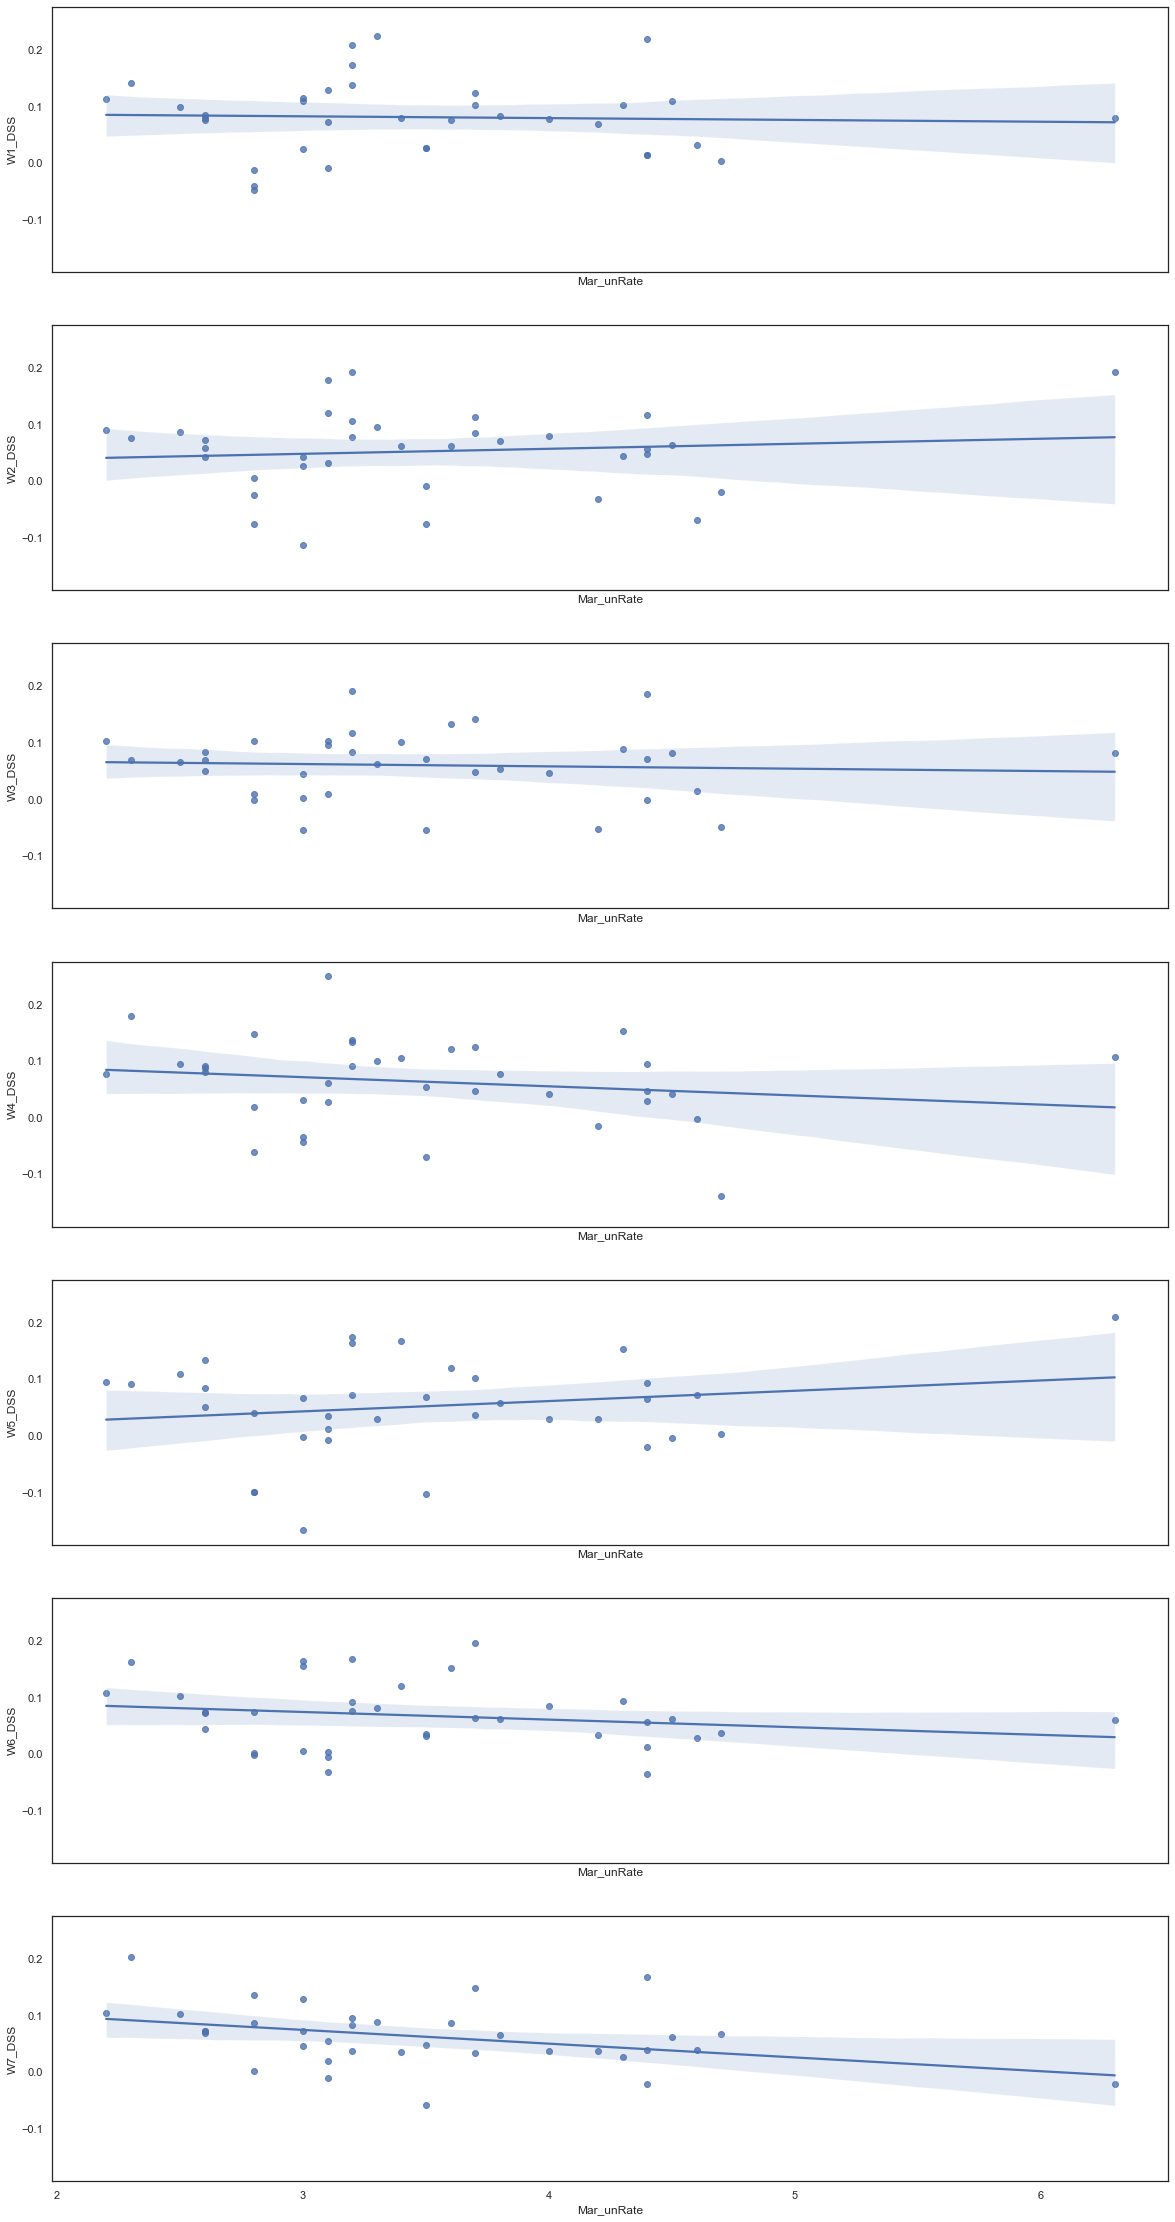

In [386]:
f, axes = plt.subplots(7, 1, figsize=(20, 40),  sharey=True, sharex=True)
ax = sns.regplot(x="Mar_unRate", y="W1_DSS", data=Week_DSS_unemployment, ax=axes[0])
sns.regplot(x="Mar_unRate", y="W2_DSS", data=Week_DSS_unemployment, ax=axes[1])
sns.regplot(x="Mar_unRate", y="W3_DSS", data=Week_DSS_unemployment, ax=axes[2])
sns.regplot(x="Mar_unRate", y="W4_DSS", data=Week_DSS_unemployment, ax=axes[3])
sns.regplot(x="Mar_unRate", y="W5_DSS", data=Week_DSS_unemployment, ax=axes[4])
sns.regplot(x="Mar_unRate", y="W6_DSS", data=Week_DSS_unemployment, ax=axes[5])
sns.regplot(x="Mar_unRate", y="W7_DSS", data=Week_DSS_unemployment, ax=axes[6])
plt.savefig("DSSbyMarchUnemploymentWeekly", tight_layout=False)

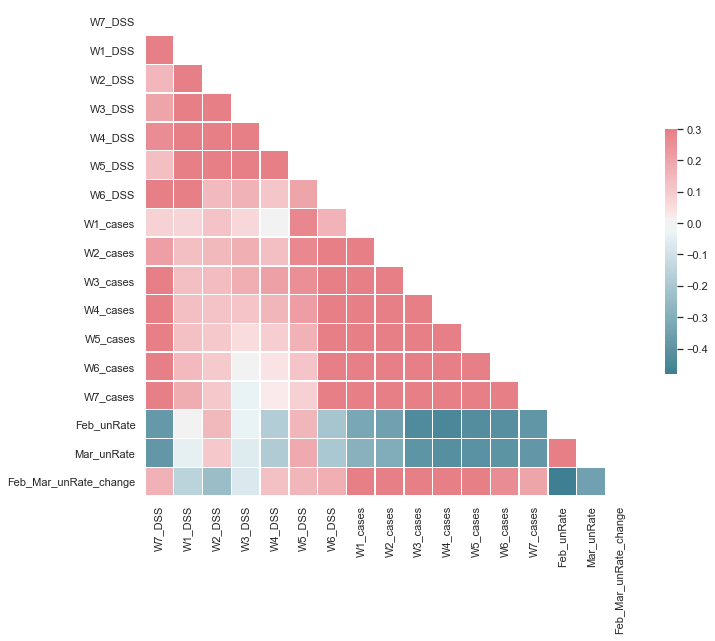

In [387]:
## Correlation plot
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = Week_DSS_unemployment

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [388]:
# Urban and Rural areas
urban_rural = pd.read_excel('PctUrbanRural_County.xls')
Week_DSS_stay_cases = pd.merge(Week_DSS_stay_cases, urban_rural, on='county_name')
Week_DSS_stay_deaths = pd.merge(Week_DSS_stay_deaths, urban_rural, on='county_name')

In [389]:
Week_DSS_stay_cases

,county_name,W7_DSS,W1_DSS,W2_DSS,W3_DSS,W4_DSS,W5_DSS,W6_DSS,W1_cases,W2_cases,...,POP_UC,POPPCT_UC,AREA_UC,AREAPCT_UC,POPDEN_UC,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,POPDEN_RURAL
0,alexandria city,0.102558,0.098810,0.085902,0.066707,0.094970,0.108611,0.101765,1.265135,2.447206,...,0,0.00,0,0.00,NaN,0,0.00,0,0.00,NaN
1,arlington county,0.104959,0.112319,0.090507,0.102226,0.076196,0.095533,0.106922,1.578927,2.480555,...,0,0.00,0,0.00,NaN,0,0.00,0,0.00,NaN
2,bedford county,-0.058115,0.026209,-0.075111,-0.054243,-0.069129,-0.102248,0.032375,0.192535,0.231042,...,735,1.07,2255741,0.12,843.9,53864,78.43,1894636275,97.15,73.6
3,bristol city,0.168044,0.218658,0.117301,0.186105,0.094929,0.093367,0.056468,0.059372,0.059372,...,0,0.00,0,0.00,NaN,7,0.04,863030,2.56,21.0
4,charlotte county,0.039061,0.031749,-0.067929,0.014497,-0.002021,0.072703,0.027806,0.330715,0.661430,...,0,0.00,0,0.00,NaN,12586,100.00,1230945745,100.00,26.5
5,charlottesville city,0.072350,0.075219,0.042594,0.050433,0.081157,0.050968,0.044829,0.658986,0.871562,...,0,0.00,0,0.00,NaN,0,0.00,0,0.00,NaN
6,chesterfield county,0.019493,-0.008896,0.121072,0.102975,0.060794,-0.007122,0.003884,0.615707,0.916196,...,0,0.00,0,0.00,NaN,18749,5.93,581042944,53.00,83.6
7,culpeper county,0.095257,0.136908,0.106351,0.082975,0.091694,0.072725,0.092394,0.376611,0.852329,...,17778,38.08,19619776,2.00,2346.9,28911,61.92,962591095,98.00,77.8
8,danville city,-0.020516,0.080147,0.192104,0.082650,0.106554,0.210137,0.059075,0.481788,0.650414,...,41111,95.48,70539131,63.44,1509.5,1944,4.52,40659564,36.56,123.8
9,essex county,0.061302,0.109145,0.064345,0.081910,0.040904,-0.004147,0.060956,0.000000,0.181225,...,2534,22.72,7079892,1.06,927.0,8617,77.28,658864501,98.94,33.9


In [390]:
# Check weekly DSS average by urban/rural percentage
from scipy.stats import pearsonr
corr, pvalue = pearsonr(Week_DSS_stay_cases['W1_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W2_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W3_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W4_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W5_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W6_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W7_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)


Week 1: p-value: 0.20785477878514005 Pearsons correlation: 0.215
Week 2: p-value: 0.07265496710400816 Pearsons correlation: 0.303
Week 3: p-value: 0.7000713736597035 Pearsons correlation: 0.066
Week 4: p-value: 0.359112691717962 Pearsons correlation: 0.157
Week 5: p-value: 0.19616926811138138 Pearsons correlation: 0.221
Week 6: p-value: 0.36637522586877685 Pearsons correlation: 0.155
Week 7: p-value: 0.27532300000950577 Pearsons correlation: 0.187


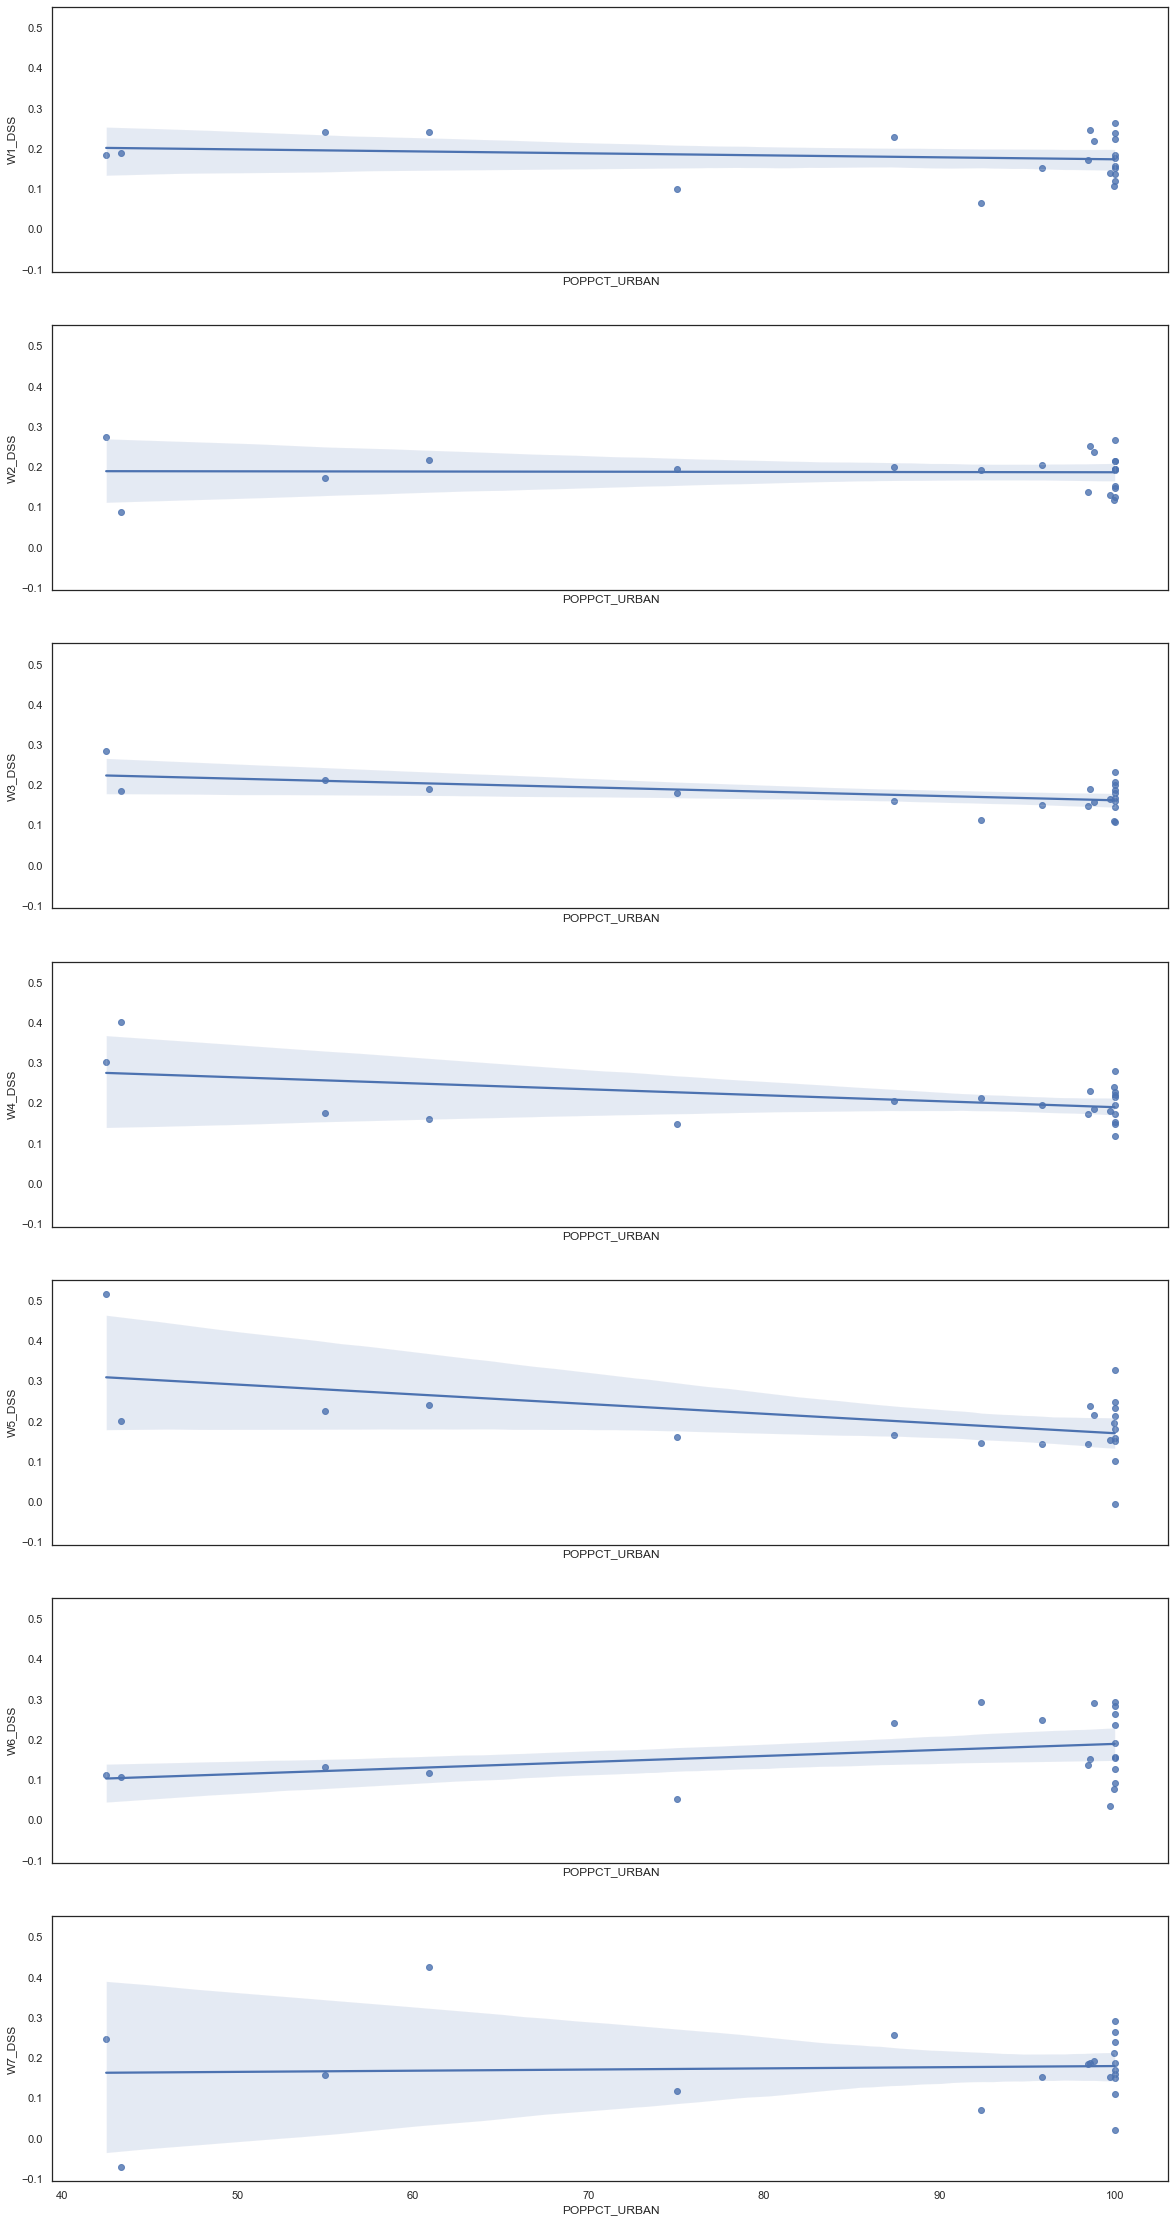

In [365]:
f, axes = plt.subplots(7, 1, figsize=(20, 40),  sharey=True, sharex=True)
ax = sns.regplot(x="POPPCT_URBAN", y="W1_DSS", data=Week_DSS_stay_cases, ax=axes[0])
sns.regplot(x="POPPCT_URBAN", y="W2_DSS", data=Week_DSS_stay_cases, ax=axes[1])
sns.regplot(x="POPPCT_URBAN", y="W3_DSS", data=Week_DSS_stay_cases, ax=axes[2])
sns.regplot(x="POPPCT_URBAN", y="W4_DSS", data=Week_DSS_stay_cases, ax=axes[3])
sns.regplot(x="POPPCT_URBAN", y="W5_DSS", data=Week_DSS_stay_cases, ax=axes[4])
sns.regplot(x="POPPCT_URBAN", y="W6_DSS", data=Week_DSS_stay_cases, ax=axes[5])
sns.regplot(x="POPPCT_URBAN", y="W7_DSS", data=Week_DSS_stay_cases, ax=axes[6])
plt.savefig("DSSbyPopUrbanWeekly", tight_layout=False)

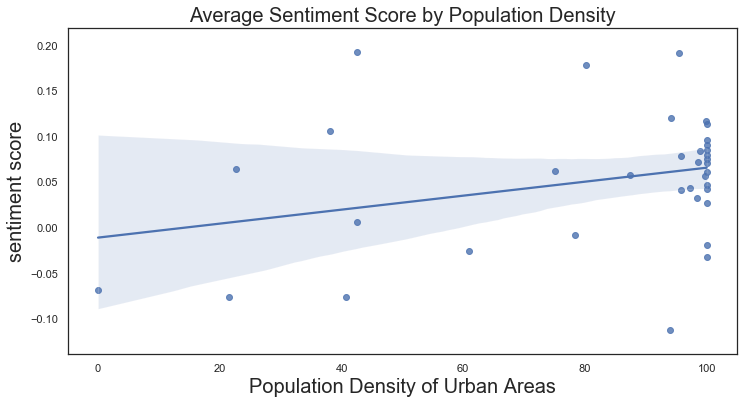

In [393]:
# Avg Weekly Sentiment Score by Percent Change
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="POPPCT_URBAN", y="W2_DSS",
                     data=Week_DSS_stay_cases).set_title("Average Sentiment Score by Population Density",fontsize=20)
#plt.savefig("Neutral Tweets", tight_layout=False)
plt.xlabel("Population Density of Urban Areas", fontsize=20)
plt.ylabel("sentiment score", fontsize=20)
plt.show()

In [394]:
# Check weekly DSS average by cum cases per 1000
corr, pvalue = pearsonr(Week_DSS_stay_cases['W1_DSS'], Week_DSS_stay_cases['W1_cases'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W2_DSS'], Week_DSS_stay_cases['W2_cases'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W3_DSS'], Week_DSS_stay_cases['W3_cases'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W4_DSS'], Week_DSS_stay_cases['W4_cases'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W5_DSS'], Week_DSS_stay_cases['W5_cases'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W6_DSS'], Week_DSS_stay_cases['W6_cases'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W7_DSS'], Week_DSS_stay_cases['W7_cases'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)



Week 1: p-value: 0.6551638300482743 Pearsons correlation: 0.077
Week 2: p-value: 0.3952933028830563 Pearsons correlation: 0.146
Week 3: p-value: 0.30325011318844264 Pearsons correlation: 0.176
Week 4: p-value: 0.3655877721492494 Pearsons correlation: 0.155
Week 5: p-value: 0.331824459096607 Pearsons correlation: 0.166
Week 6: p-value: 0.053577620305058776 Pearsons correlation: 0.324
Week 7: p-value: 0.017519471381350682 Pearsons correlation: 0.394


In [395]:
# Check weekly DSS average by cum deaths per 1000
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W1_DSS'], Week_DSS_stay_deaths['W1_deaths'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W2_DSS'], Week_DSS_stay_deaths['W2_deaths'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W3_DSS'], Week_DSS_stay_deaths['W3_deaths'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W4_DSS'], Week_DSS_stay_deaths['W4_deaths'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W5_DSS'], Week_DSS_stay_deaths['W5_deaths'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W6_DSS'], Week_DSS_stay_deaths['W6_deaths'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W7_DSS'], Week_DSS_stay_deaths['W7_deaths'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)


Week 1: p-value: 0.7041962259559932 Pearsons correlation: 0.066
Week 2: p-value: 0.7544877006657323 Pearsons correlation: 0.054
Week 3: p-value: 0.20098381325562814 Pearsons correlation: 0.218
Week 4: p-value: 0.31537301978562887 Pearsons correlation: 0.172
Week 5: p-value: 0.12262551761377942 Pearsons correlation: 0.262
Week 6: p-value: 0.1415065417827989 Pearsons correlation: 0.250
Week 7: p-value: 0.03425350958953233 Pearsons correlation: 0.354


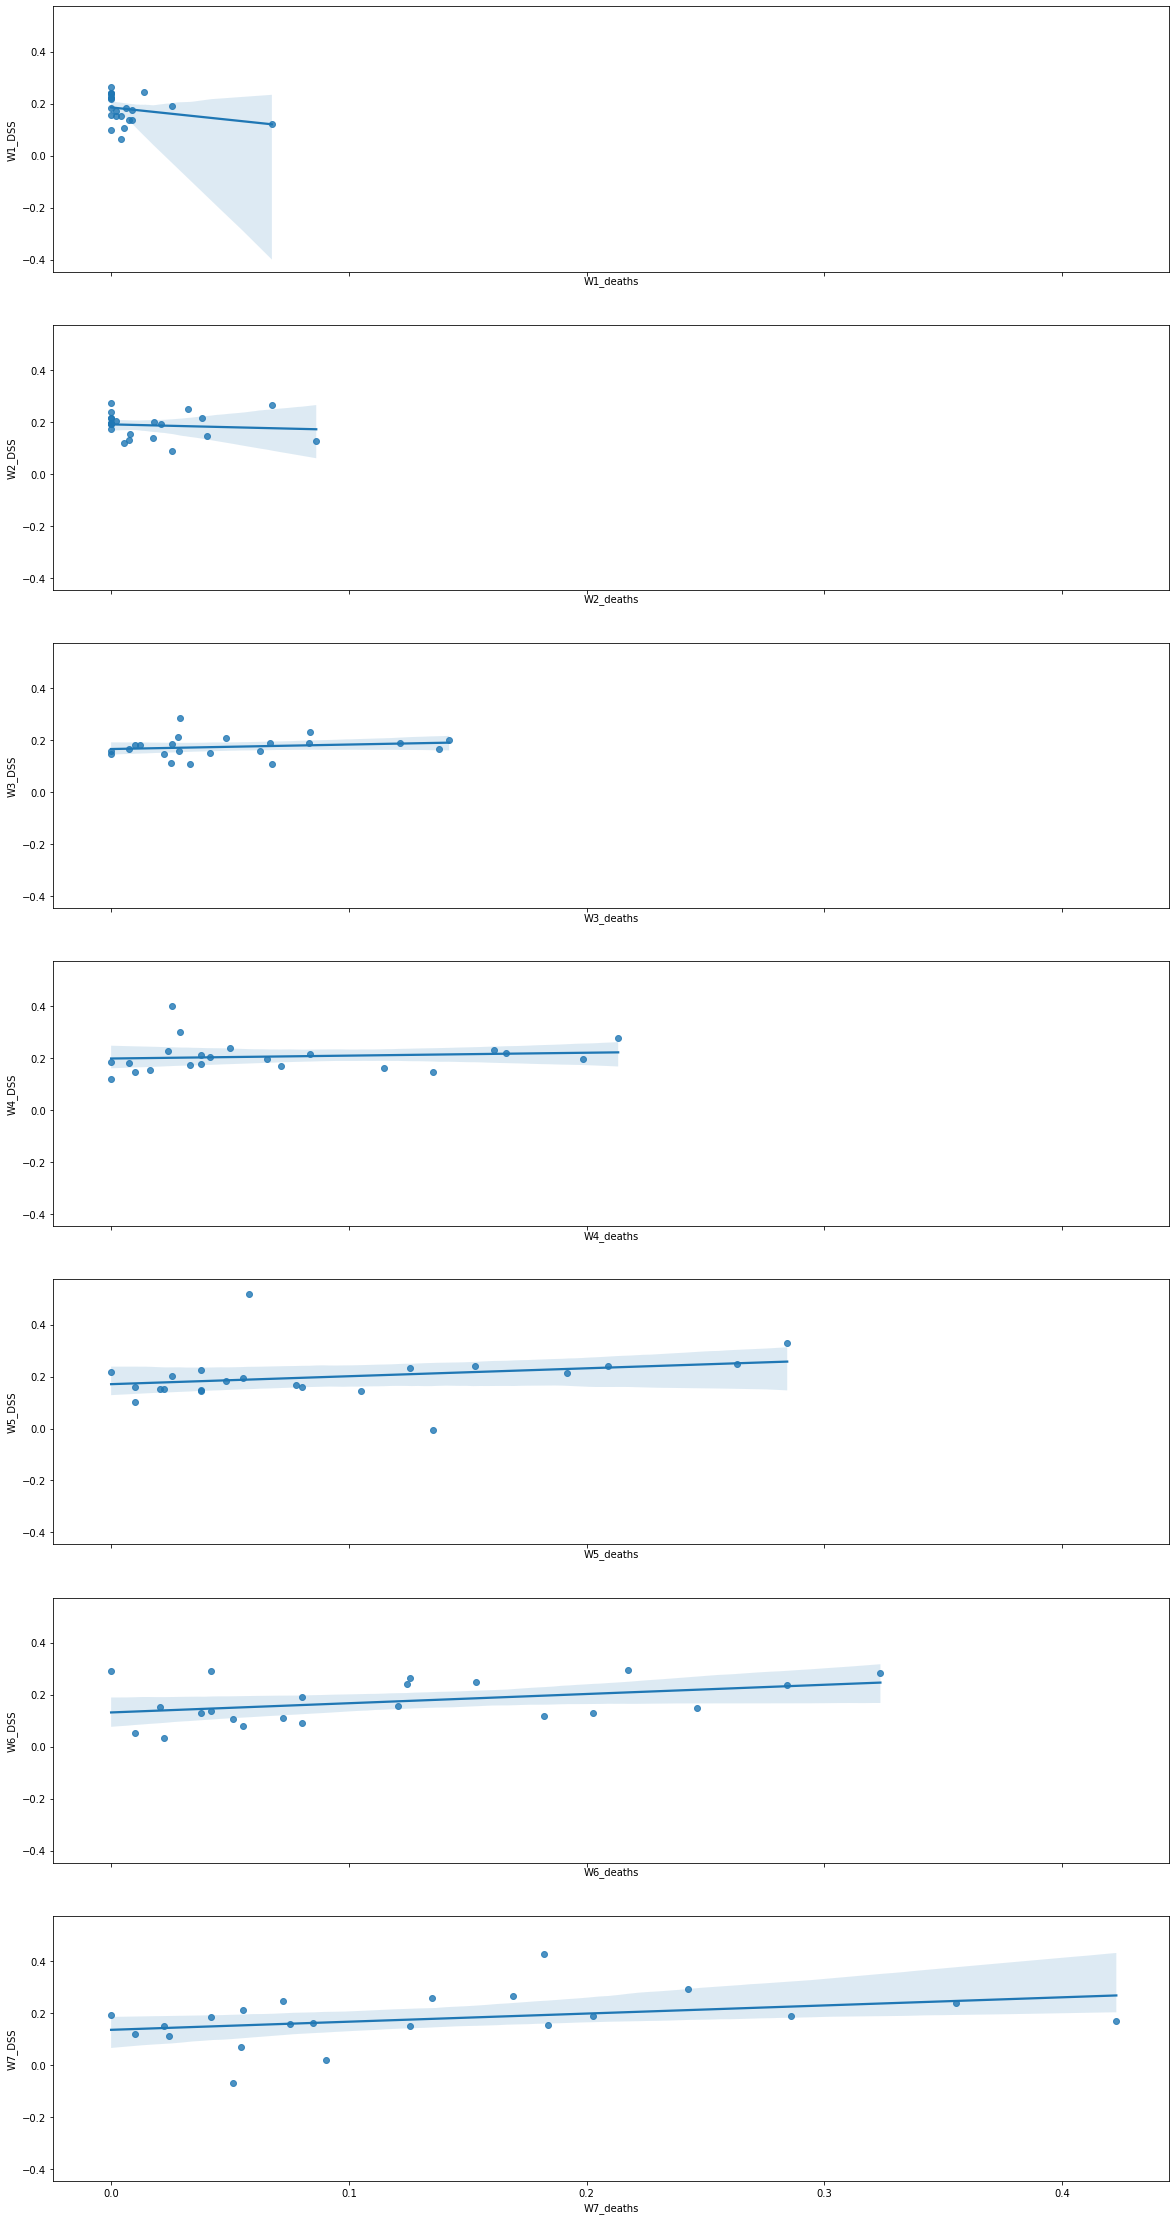

In [275]:
f, axes = plt.subplots(7, 1, figsize=(20, 40),  sharey=True, sharex=True)
ax = sns.regplot(x="W1_deaths", y="W1_DSS", data=Week_DSS_stay_deaths, ax=axes[0])
sns.regplot(x="W2_deaths", y="W2_DSS", data=Week_DSS_stay_deaths, ax=axes[1])
sns.regplot(x="W3_deaths", y="W3_DSS", data=Week_DSS_stay_deaths, ax=axes[2])
sns.regplot(x="W4_deaths", y="W4_DSS", data=Week_DSS_stay_deaths, ax=axes[3])
sns.regplot(x="W5_deaths", y="W5_DSS", data=Week_DSS_stay_deaths, ax=axes[4])
sns.regplot(x="W6_deaths", y="W6_DSS", data=Week_DSS_stay_deaths, ax=axes[5])
sns.regplot(x="W7_deaths", y="W7_DSS", data=Week_DSS_stay_deaths, ax=axes[6])
plt.savefig("DSSbyDeathsWeekly", tight_layout=False)



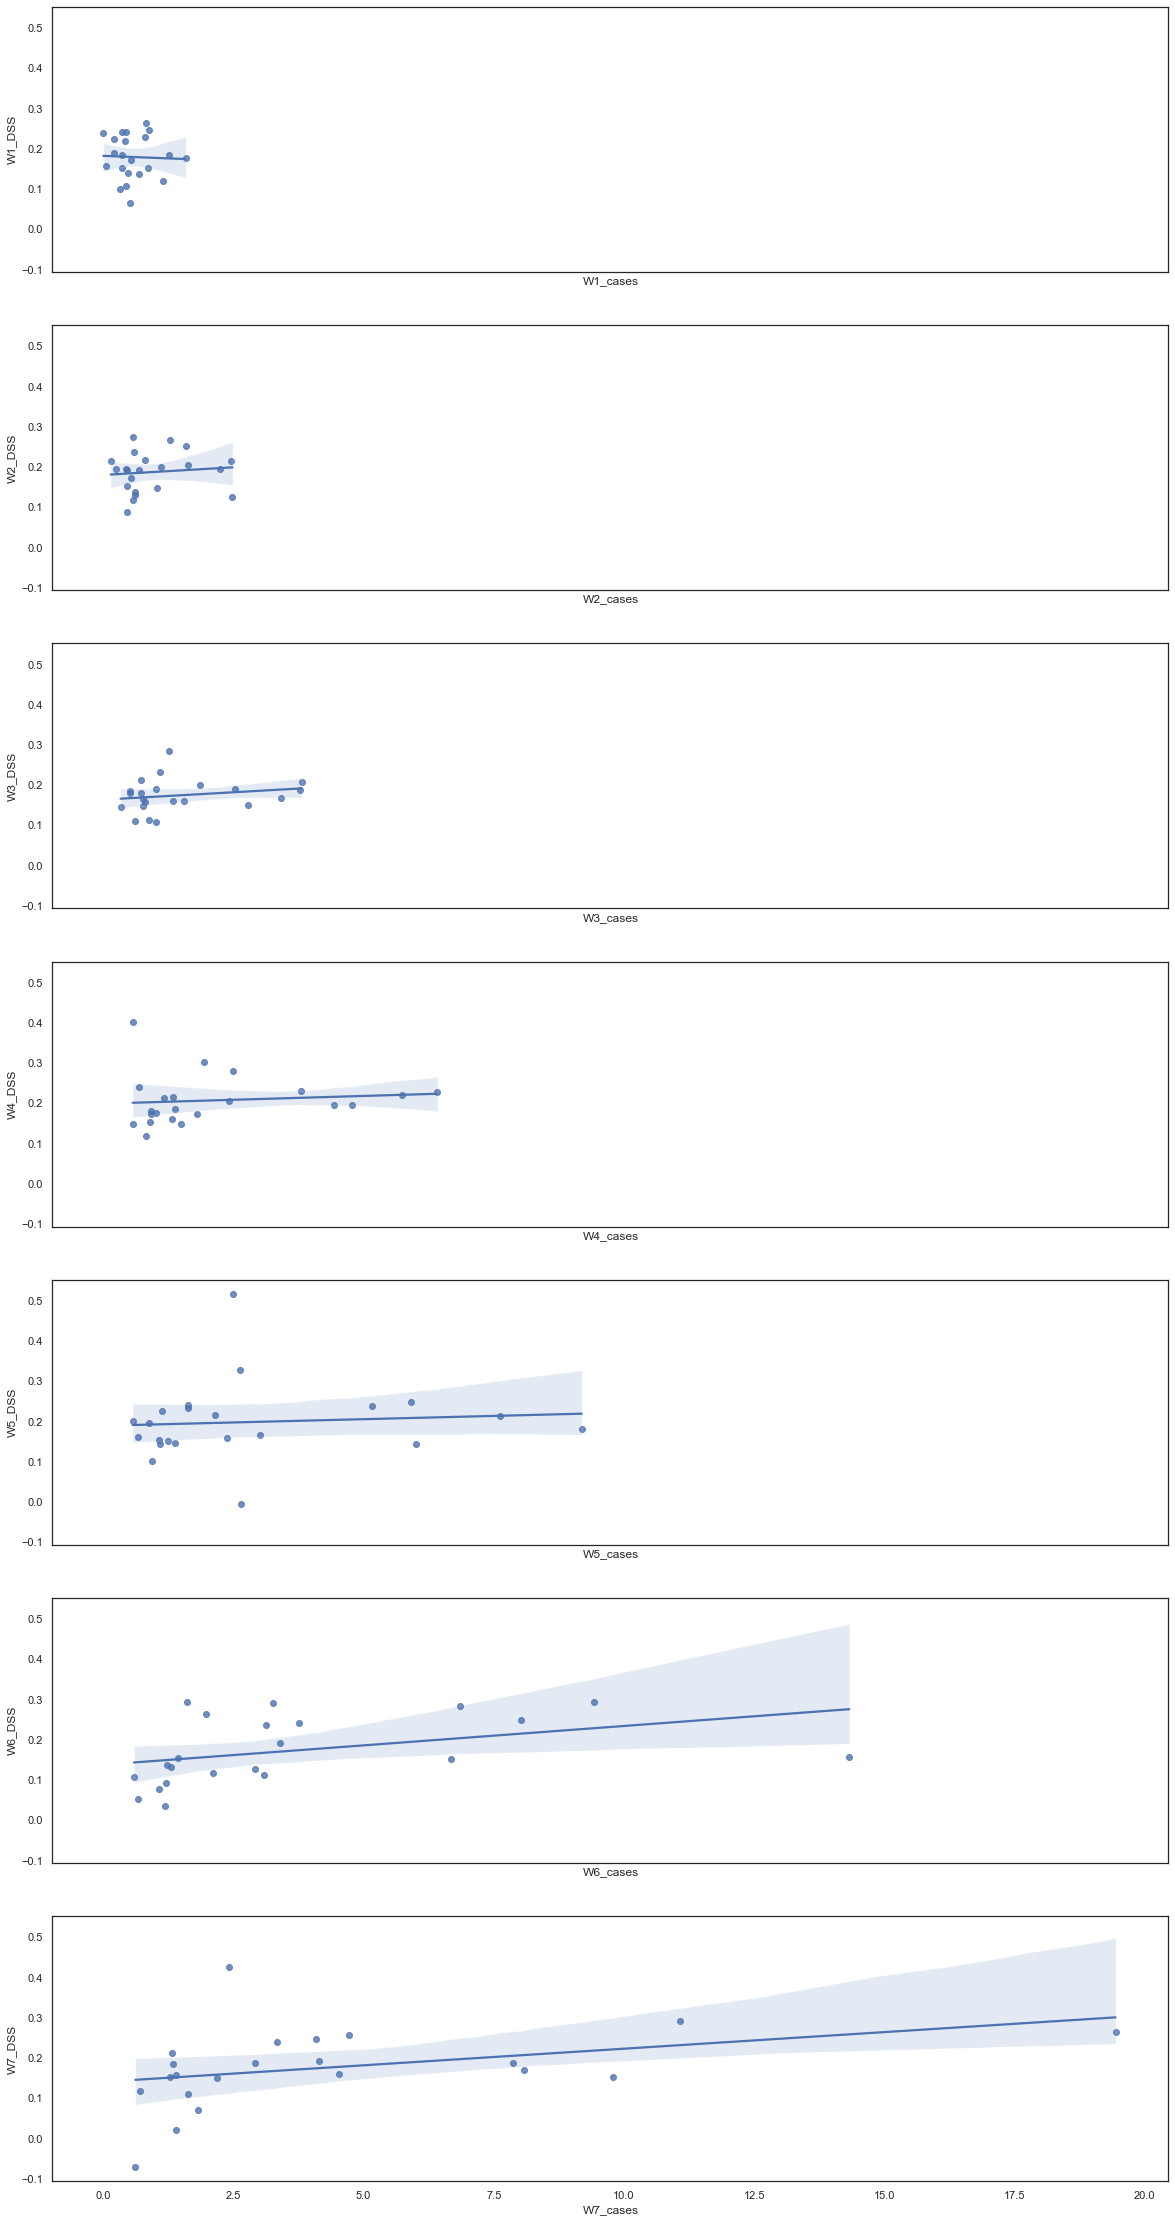

In [359]:
f, axes = plt.subplots(7, 1, figsize=(20, 40),  sharey=True, sharex=True)
ax = sns.regplot(x="W1_cases", y="W1_DSS", data=Week_DSS_stay_cases, ax=axes[0])
sns.regplot(x="W2_cases", y="W2_DSS", data=Week_DSS_stay_cases, ax=axes[1])
sns.regplot(x="W3_cases", y="W3_DSS", data=Week_DSS_stay_cases, ax=axes[2])
sns.regplot(x="W4_cases", y="W4_DSS", data=Week_DSS_stay_cases, ax=axes[3])
sns.regplot(x="W5_cases", y="W5_DSS", data=Week_DSS_stay_cases, ax=axes[4])
sns.regplot(x="W6_cases", y="W6_DSS", data=Week_DSS_stay_cases, ax=axes[5])
sns.regplot(x="W7_cases", y="W7_DSS", data=Week_DSS_stay_cases, ax=axes[6])
plt.savefig("DSSbyCasesWeekly", tight_layout=False)


In [396]:
location_GT20 = pd.read_csv("location_GT20.csv")
location_GT20

,Unnamed: 0,county_name,neg,neu,pos,compound,index,count
0,4,franklin city,0.157778,0.775148,0.067000,-0.171448,30702.703704,27.0
1,5,floyd county,0.120000,0.819242,0.060758,-0.159555,34618.370968,62.0
2,6,cumberland county,0.092213,0.850000,0.057803,-0.142795,23653.065574,61.0
3,7,russell county,0.093885,0.839000,0.067115,-0.142327,37930.653846,26.0
4,8,richmond county,0.089333,0.838083,0.072639,-0.142308,31577.083333,36.0
...,...,...,...,...,...,...,...,...
99,124,james city county,0.033862,0.853069,0.113069,0.251897,21887.551724,29.0
100,127,brunswick county,0.034528,0.855333,0.110139,0.264839,35687.583333,36.0
101,128,buckingham county,0.033105,0.854709,0.112244,0.277197,34190.662791,86.0
102,129,pulaski county,0.062250,0.789962,0.147808,0.296825,33445.730769,52.0


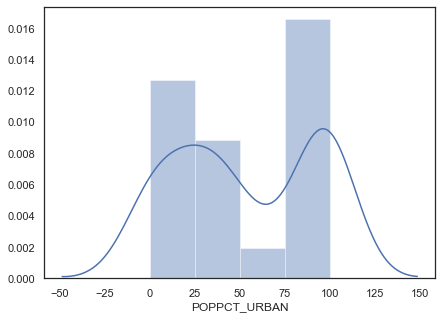

In [397]:
location_GT20_URB_RURAL = pd.merge(location_GT20, urban_rural, on='county_name')
plt.figure(figsize=(7, 5))
ax = sns.distplot(location_GT20_URB_RURAL.POPPCT_URBAN)

In [399]:
from scipy.stats import pearsonr
# calculate Pearson's correlation - Average overall sentiment by percent urban
corr, pvalue = pearsonr(location_GT20_URB_RURAL['compound'], location_GT20_URB_RURAL['POPPCT_URBAN'])
print(f"p-value: {pvalue}")
print('Pearsons correlation: %.3f' % corr)
# slight negative correlation but not significant

p-value: 0.14540456115175635
Pearsons correlation: 0.144


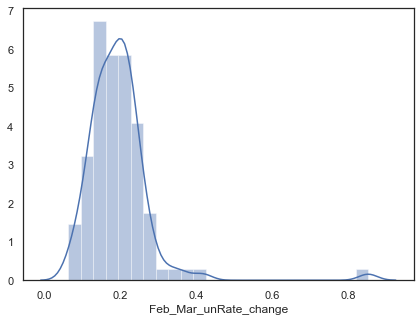

In [400]:
location_GT20_UNEMPLOYMENT = pd.merge(location_GT20, VA_employment, on='county_name')
plt.figure(figsize=(7, 5))
ax = sns.distplot(location_GT20_UNEMPLOYMENT.Feb_Mar_unRate_change)

In [404]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(location_GT20_UNEMPLOYMENT['Feb_Mar_unRate_change'], location_GT20_UNEMPLOYMENT['compound'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(location_GT20_UNEMPLOYMENT['Mar_unRate'], location_GT20_UNEMPLOYMENT['compound'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Week 1: p-value: 0.026158686251572565 Pearsons correlation: 0.218
Week 1: p-value: 0.5184271579753349 Pearsons correlation: -0.064


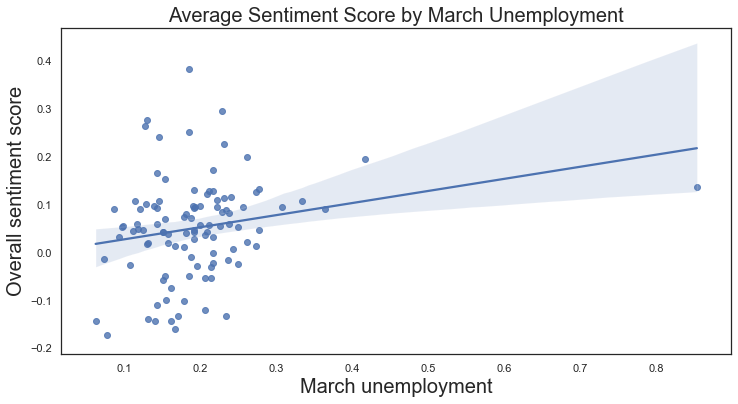

In [406]:
# Avg Weekly Sentiment Score by Percent Urban
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="Feb_Mar_unRate_change", y="compound",
                     data=location_GT20_UNEMPLOYMENT).set_title("Average Sentiment Score by March Unemployment",fontsize=20)
plt.savefig("Avg Sent by Percent Change in Unemployment", tight_layout=False)
plt.xlabel("March unemployment", fontsize=20)
plt.ylabel("Overall sentiment score", fontsize=20)
plt.show()